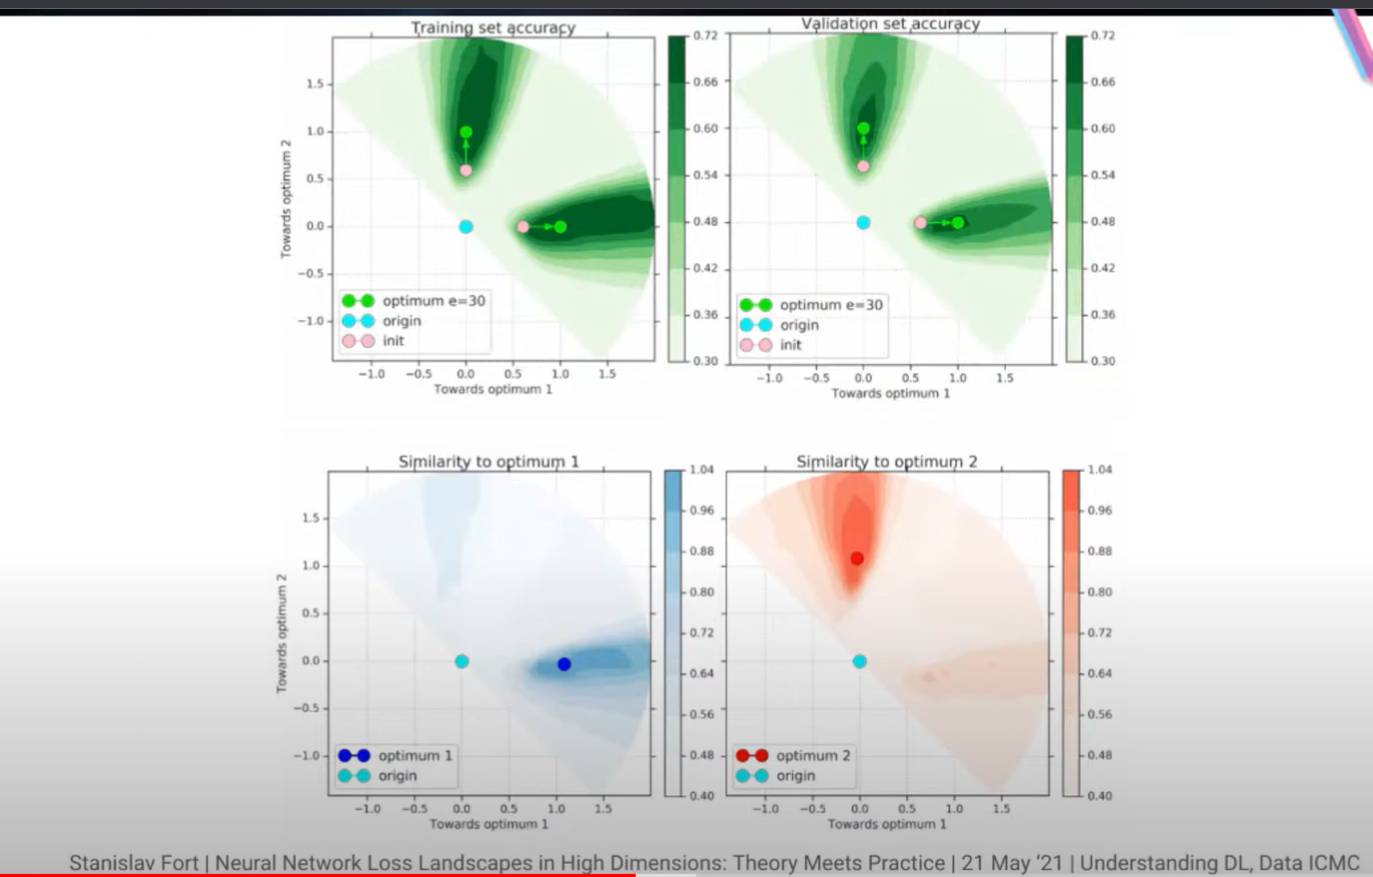

In [1]:
! nvidia-smi

Thu Feb 16 14:14:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0   286W / 300W |  12902MiB / 16384MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
device = 'cuda:3'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../..')

In [5]:
import lovely_tensors as lt
lt.monkey_patch()

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
from IPython.display import display, clear_output

In [7]:
from pathlib import Path
DATA_DIR = Path('../../data')

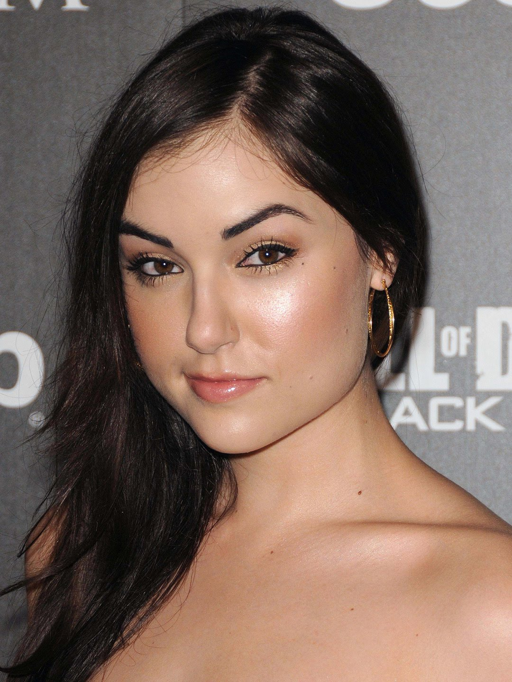

In [8]:
image_pil = Image.open(DATA_DIR/'sasha.jpg')

W, H = image_pil.size
aspect = H/W

W = 512
H = int( W * aspect )
image_pil = image_pil.resize((W,H))

image_pil

In [9]:
image = torch.tensor(np.asarray(image_pil)).permute(2,0,1)/255
H, W = image.shape[1:]
image = image.to(device)
image

tensor[3, 682, 512] n=1047552 x∈[0., 1.000] μ=0.422 σ=0.256 cuda:3

In [10]:
def get_uvs(H, W, device='cpu'):
    xs = torch.linspace(-1, 1, W).to(device)
    ys = torch.linspace(-1, 1, H).to(device)

    x, y = torch.meshgrid(xs, ys, indexing='xy')
    uvs = torch.stack([x,y], dim=-1)
    return uvs

In [11]:
uvs = get_uvs(H, W, device='cpu').to(device)
uvs

tensor[682, 512, 2] n=698368 x∈[-1.000, 1.000] μ=-4.719e-09 σ=0.578 cuda:3

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


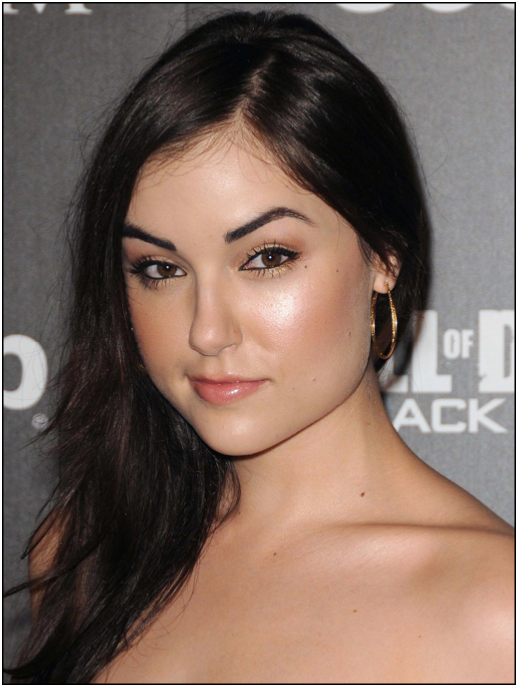

In [12]:
F.grid_sample(image[None], uvs[None]).rgb

In [13]:
def tensor2pil(t): 
    return Image.fromarray((t.detach().permute(1,2,0).clip(0, 1).cpu().numpy() * 255).astype(np.uint8))

In [14]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [15]:
try:
    from prettytable import PrettyTable
except:
    ! pip install prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [16]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [17]:
def init_siren():
    return Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=4, outermost_linear=True)

In [18]:
siren = init_siren()
count_parameters(siren)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |    512     |
|  net.0.linear.bias  |    256     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    256     |
| net.2.linear.weight |   65536    |
|  net.2.linear.bias  |    256     |
| net.3.linear.weight |   65536    |
|  net.3.linear.bias  |    256     |
| net.4.linear.weight |   65536    |
|  net.4.linear.bias  |    256     |
|     net.5.weight    |    768     |
|      net.5.bias     |     3      |
+---------------------+------------+
Total Trainable Params: 264707


264707

In [19]:
steps_til_summary = 250
steps_til_vis = 500

In [20]:
from tqdm.cli import tqdm

In [21]:
def train(model, n_iters=2000, seed=42, lr=1e-2):
    print('SEED =', seed)
    seed_all(seed)

    model = model.to(device)
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

    # import wandb
    # wandb.init(project='my-neural-fields', name='uber_inet_00')

    count_parameters(model)
    step_i = 0

    losses = []
    pbar = tqdm(range(n_iters))

    for step_i in pbar:
        pred_image = model(uvs)
        pred_image = pred_image.permute(2,0,1)
        loss = F.mse_loss(pred_image, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        pbar.set_description(f'Loss={loss.item():.6f}')
        # wandb.log({
        #     'loss': loss.item(),
        #     'step': step_i
        # })


    #     if (step_i%steps_til_vis == 0):
    #         wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})

        if (step_i%steps_til_summary==0):
            clear_output()
            print(f'step_i={step_i} {loss.item():.4f}')
            display(pred_image.rgb)
            skip_n = 75
            skip_n = min(skip_n, step_i)
            plt.plot(losses[skip_n:])
            plt.show()


        step_i += 1
        
    return model

step_i=250 0.0005


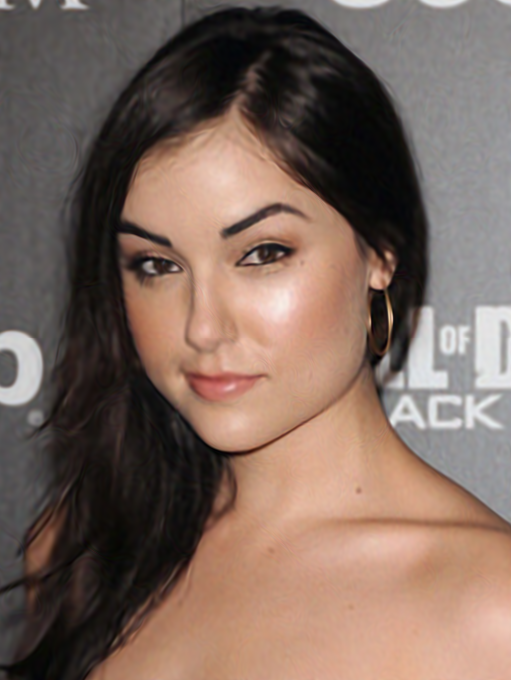

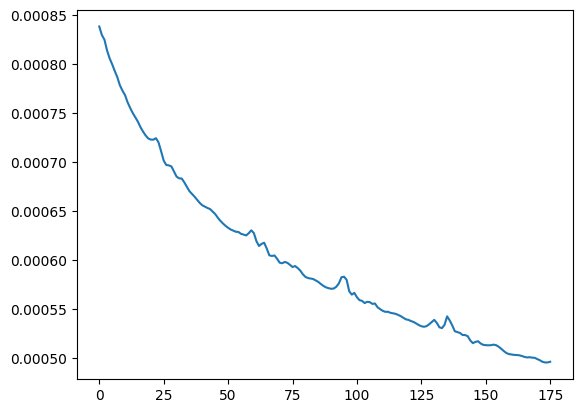

Loss=0.000397: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.48it/s]


In [29]:
model_0 = train(init_siren(), lr=5e-4, seed=0, n_iters=500)

step_i=250 0.0005


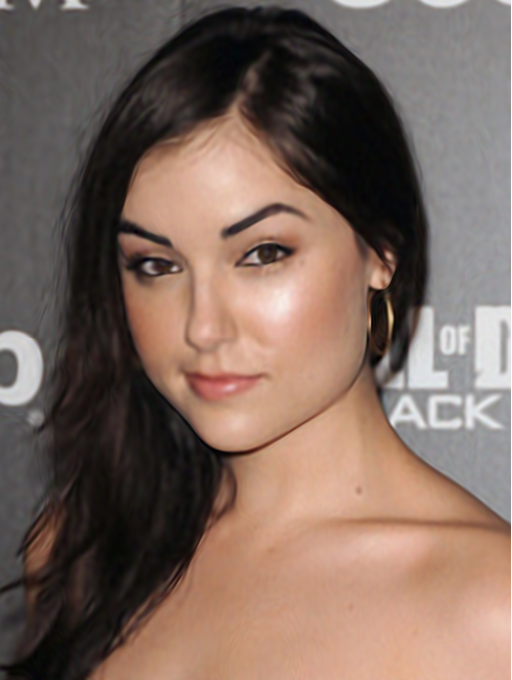

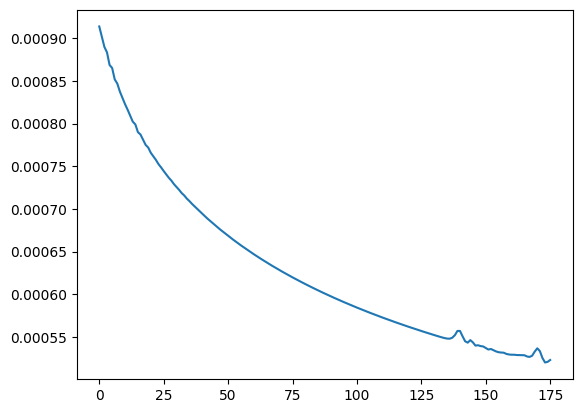

Loss=0.000416: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.47it/s]


In [52]:
model_1 = train(init_siren(), lr=5e-4, seed=1, n_iters=500)

In [53]:
# model_1 = train(UberNet(), lr=1e-2, seed=1)

# Manipulate weights

In [54]:
from collections import OrderedDict


def product(li):
    p = 1
    for e in li:
        p *= e
    return p

def params2vec(state_dict):
    state_dict_shapes = OrderedDict()
    params = []

    for name, p in state_dict.items():
        state_dict_shapes[name] = p.shape
        params.append(p.flatten())

    param_vec = torch.cat(params)
    return param_vec, state_dict_shapes

def vec2params(param_vec, state_dict_shapes):
    offset = 0
    reconstructed_state_dict = OrderedDict()

    for name, shape in state_dict_shapes.items():
        n = product(shape)
        p = param_vec[offset:offset+n]
        p = p.reshape(shape)

        reconstructed_state_dict[name] = p

        offset += n

    return reconstructed_state_dict

In [55]:
param_vec_0, state_dict_shapes = params2vec(model_0.state_dict())
param_vec_0

tensor[264707] x∈[-0.696, 0.706] μ=-9.920e-06 σ=0.019 cuda:3

In [56]:
param_vec_1, state_dict_shapes = params2vec(model_1.state_dict())
param_vec_1

tensor[264707] x∈[-0.705, 0.706] μ=1.389e-06 σ=0.019 cuda:3

In [57]:
from copy import deepcopy

# Fort plane

In [58]:
def proj_u(v, u): return ((v@u)/(u@u)) * u

In [59]:
model = init_siren()

In [60]:
wx = param_vec_0.cpu()
wy = param_vec_1.cpu()
# w1 = torch.randn_like(w0)
# w2 = torch.randn_like(w0)

# u = w1 - w0
# v = w2 - w0

# v = v - proj_u(v, u)
# q = q - proj_u(q, u) - proj_u(q, v)

# u = F.normalize(u, dim=0) * w0.norm()
# v = F.normalize(v, dim=0) * u.norm()


n_steps = 50
half_range = 1.5

losses = torch.zeros(n_steps, n_steps)

for i,x in tqdm( enumerate( torch.linspace(-half_range, half_range, n_steps) ) ):
    for j,y in enumerate( torch.linspace(-half_range, half_range, n_steps) ):
        w_xy = x*wx + y*wy

        model.load_state_dict(vec2params(w_xy, state_dict_shapes))
        model = model.to(device)
        
        with torch.no_grad():
            pred_image = model(uvs)
        pred_image = pred_image.permute(2,0,1)
        loss = F.mse_loss(pred_image, image)
        
        losses[i,j] = loss
        
        
        

50it [02:10,  2.62s/it]


In [61]:
losses

tensor[50, 50] n=2500 x∈[0.014, 0.313] μ=0.163 σ=0.059

In [62]:
X, Y = np.meshgrid(np.linspace(-half_range, half_range, n_steps), np.linspace(-half_range, half_range, n_steps))

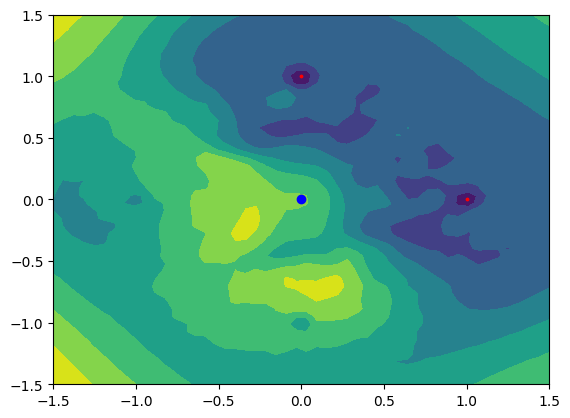

In [73]:
ax = plt.subplot(1, 1, 1)

ax.contourf(X, Y, losses)
ax.scatter([0], [0], c='blue')
ax.scatter([1], [0], c='red', s=3)
ax.scatter([0], [1], c='red', s=3)

In [80]:
class PE(nn.Module):
    """
    positional encoding
    """
    def __init__(self, p=10, nfreq=128):
        """
        P: (F, d) encoding matrix
        d: dimension of data
        """
        super().__init__()
        self.nfreq = nfreq
        P = 2 * np.pi * p * torch.normal(torch.zeros(2, nfreq)-0.1,
                                                  torch.ones(2, nfreq))  # (2, 2*10)
        self.register_buffer("P", P) # same function as "self.P = p", but p will not attend into backpropagate
    def forward(self, x):
        """
        x: (B, d)
        """
        
        shape = x.shape[:-1]
        
        x = x.reshape(-1, 2)
        x_ = x @ self.P # (B, F)
        x = torch.cat([torch.sin(x_), torch.cos(x_)], -1) # (B, 2*F)
        
        x = x.reshape(*shape, self.nfreq*2)
        return x
    @property
    def out_dim(self):
        return self.P.shape[1]*2

In [83]:
class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        
    def forward(self, x):
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h].cos()
        return o
    
h=32
class UberNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            PE(),
            UberLayer(256, h),
            UberLayer(h, h),
            # UberLayer(h, h),
            nn.Linear(h, 3)
        )
        
    def forward(self, x):
        return self.net(x)

step_i=2000 0.0006


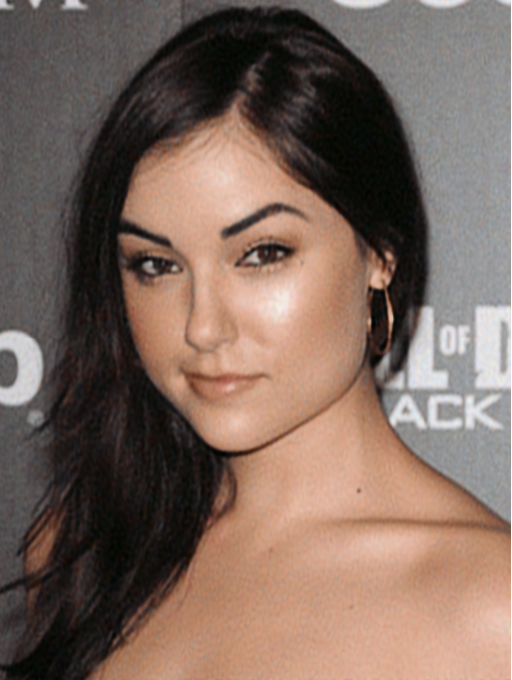

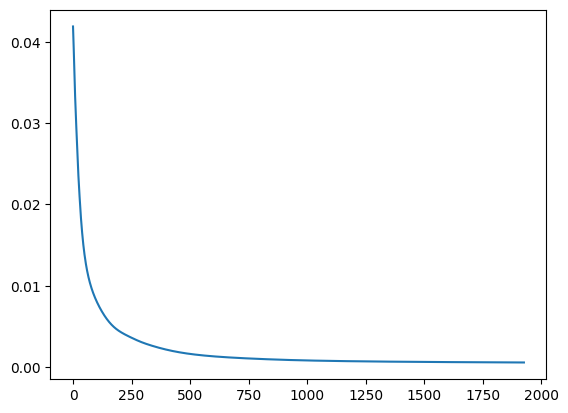

Loss=0.000579: 100%|████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:51<00:00, 38.66it/s]


In [85]:
model_0 = train(UberNet(), lr=1e-3, seed=0, n_iters=2001)

step_i=2000 0.0006


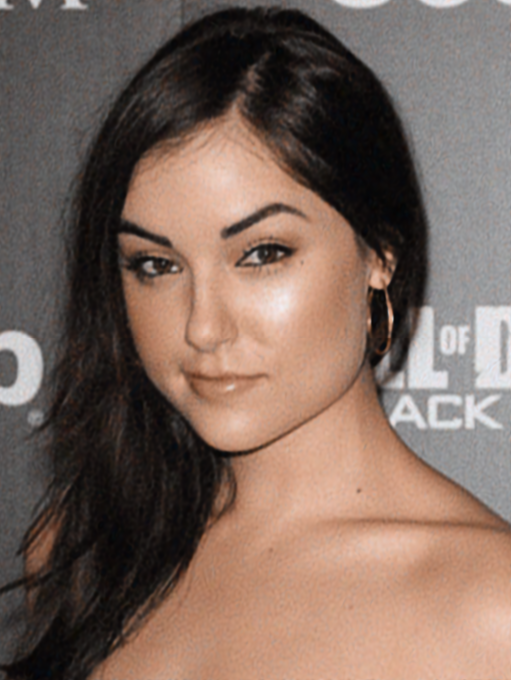

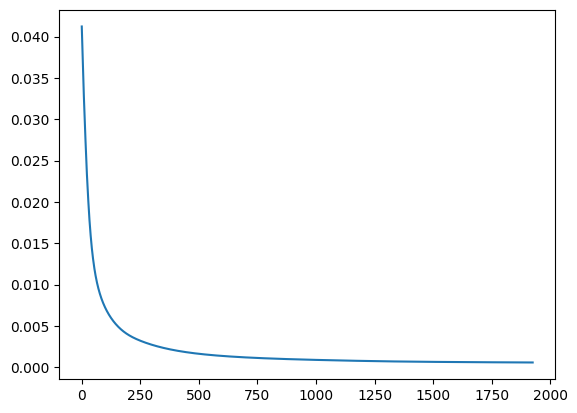

Loss=0.000570: 100%|████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:52<00:00, 38.26it/s]


In [96]:
seed_all(42)
model_1 = train(UberNet(), lr=1e-3, seed=42, n_iters=2001)

In [97]:
# model_1 = train(UberNet(), lr=1e-2, seed=1)

In [98]:
param_vec_0, state_dict_shapes = params2vec(model_0.state_dict())
param_vec_0

tensor[37475] x∈[-170.483, 208.005] μ=-0.032 σ=4.892 cuda:3

In [99]:
param_vec_1, state_dict_shapes = params2vec(model_1.state_dict())
param_vec_1

tensor[37475] x∈[-163.962, 133.083] μ=-0.017 σ=5.130 cuda:3

# Fort plane

In [100]:
def proj_u(v, u): return ((v@u)/(u@u)) * u

In [101]:
model = UberNet()

In [102]:
wx = param_vec_0.cpu()
wy = param_vec_1.cpu()
# w1 = torch.randn_like(w0)
# w2 = torch.randn_like(w0)

# u = w1 - w0
# v = w2 - w0

# v = v - proj_u(v, u)
# q = q - proj_u(q, u) - proj_u(q, v)

# u = F.normalize(u, dim=0) * w0.norm()
# v = F.normalize(v, dim=0) * u.norm()


n_steps = 50
half_range = 1.5

losses = torch.zeros(n_steps, n_steps)

for i,x in tqdm( enumerate( torch.linspace(-half_range, half_range, n_steps) ) ):
    for j,y in enumerate( torch.linspace(-half_range, half_range, n_steps) ):
        w_xy = x*wx + y*wy

        model.load_state_dict(vec2params(w_xy, state_dict_shapes))
        model = model.to(device)
        
        with torch.no_grad():
            pred_image = model(uvs)
        pred_image = pred_image.permute(2,0,1)
        loss = F.mse_loss(pred_image, image)
        
        losses[i,j] = loss
        
        
        

50it [00:30,  1.66it/s]


In [103]:
losses

tensor[50, 50] n=2500 x∈[0.076, 0.806] μ=0.321 σ=0.157

In [104]:
X, Y = np.meshgrid(np.linspace(-half_range, half_range, n_steps), np.linspace(-half_range, half_range, n_steps))

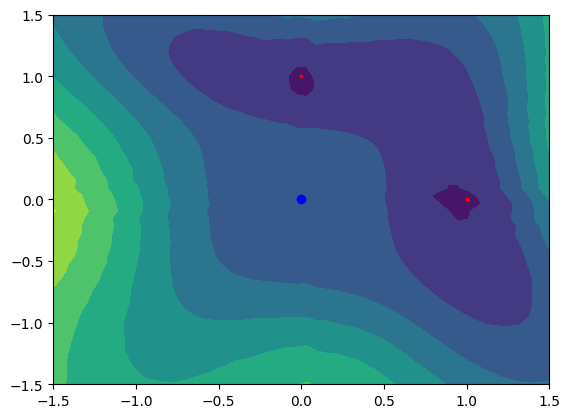

In [105]:
ax = plt.subplot(1, 1, 1)

ax.contourf(X, Y, losses)
ax.scatter([0], [0], c='blue')
ax.scatter([1], [0], c='red', s=3)
ax.scatter([0], [1], c='red', s=3)

In [ ]:
def get_center_point(map_2d):
    x, y = (torch.tensor(map_2d.shape) / 2).int()
    return map_2d[x,y]

In [ ]:
import plotly.graph_objects as go

def scatter3d(xyz, color='red', size=1.):
    return go.Scatter3d(x=xyz[:,0], y=xyz[:,1], z=xyz[:,2],
                                   mode='markers+text', marker={"size": size, 'color': color})

In [ ]:
data = []
data += [go.Surface(z=losses)]
data += [scatter3d(torch.tensor([[n_steps/2,n_steps/2,get_center_point(losses)]]), size=5.)]

fig = go.Figure(data=data)
# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))


fig.update_layout(title='UBER random plane', autosize=True,
)

fig.show()